# Visual Imitation Learning for Cart-Pole System

In [41]:
import numpy as np
import h5py
import os
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import gpytorch
from tqdm.notebook import tqdm as tqdm

## Import demonstration dataset

* `train_imgs`: (n, c, h, w), each example consists of two adjacent frames stacked together to infer velocities
* `train_actions`: (n), continuous expert action
* `train_states`: (n, 4), ground truth states of the cart-pole (x, x_dot, theta, theta_dot). We do not assume access to this during training.

In [42]:
hdf5_path = os.path.join("data", "cart_pole_visual_novice",
                         "img_demo_dataset_0.hdf5")
with h5py.File(hdf5_path, "r") as hf:
    train_imgs = torch.from_numpy(np.array(hf["train_imgs"]))
    train_actions = torch.from_numpy(np.array(hf["train_actions"]))
    train_states = torch.from_numpy(np.array(hf["train_states"]))

scale_action = 100  # scale the labels up to match to lengthscale of GP
train_actions *= scale_action

### Demostration dataset visualization

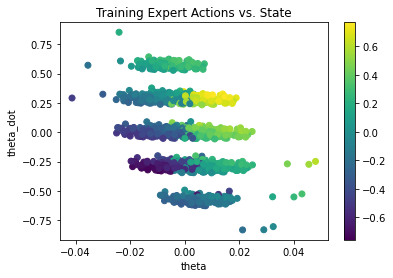

In [43]:
fig = plt.figure()
ax = plt.axes()
sc = ax.scatter(train_states[:, 2], train_states[:, 3], c=train_actions)
plt.colorbar(sc)
plt.title("Training Expert Actions vs. State")
plt.xlabel("theta")
plt.ylabel("theta_dot")
plt.show()

## Training a Visual GP Controller

In [44]:
class VisualFeatureCNNExtractor(nn.Module):

    def __init__(self,
                 cnn_scaling: int = 1,
                 in_feats: int = 3,
                 img_dim: int = 64,
                 out_feat: int = 8,
                 device='cuda'):
        super().__init__()

        self.device = device
        self.img_dim = img_dim

        model = []
        """ Convolutional part """
        out_feats = cnn_scaling * in_feats
        num_deep_layers = 2
        for _ in range(num_deep_layers):
            model += [
                nn.Conv2d(
                    in_channels=in_feats,
                    out_channels=out_feats,
                    kernel_size=5,
                    padding=2,
                    stride=1),
                nn.BatchNorm2d(out_feats),
                nn.ReLU()
            ]
            model += [nn.MaxPool2d(kernel_size=2, stride=2)]
            in_feats = out_feats
            out_feats *= cnn_scaling

        self.model = nn.Sequential(*model)

        in_feats_head = int(in_feats * (self.img_dim / num_deep_layers**2)**2)
        self.extractor_head = nn.Sequential(
            nn.Linear(in_features=in_feats_head, out_features=in_feats_head),
            nn.ReLU(),
            nn.Linear(in_features=in_feats_head, out_features=out_feat),
        ).to(self.device)

        self.to(self.device)

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        """
        input:
            img: RGB img (batch x c x h x w)
        """
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        out = self.extractor_head(out)

        return out


In [45]:
class VisualGPController(gpytorch.models.ExactGP):
    """
    Idea: use a pre-trained visual feature extractor?
        Ans: Not the best practice
    Idea: train a GP incrementally
        Ans: use model.set_train_data()
    """

    def __init__(self,
                 train_x: torch.Tensor,
                 train_y: torch.Tensor,
                 likelihood,
                 num_frames: int = 1,
                 img_dim: int = 64,
                 device='cuda') -> None:
        """
        Args:
            train_x (torch.Tensor): training images
            train_y (torch.Tensor): corresponding actions in demonstration
            likelihood ([type]): gpytorch.likelihoods.GaussianLikelihood()
            num_frames (int): number of input num_frames
            img_dim (int, optional): [description]. Defaults to 64.
            device (str, optional): [description]. Defaults to 'cuda'.
        """
        super(VisualGPController, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

        self.img_dim = img_dim
        self.num_frames = num_frames
        self.feature_extractor = VisualFeatureCNNExtractor(
            in_feats=num_frames * 3, img_dim=img_dim, device=device)

        self.to(device)

    def forward(self,
                img: torch.Tensor) -> gpytorch.distributions.MultivariateNormal:
        """
        Args:
            img (torch.Tensor): visual observation on device

        Returns:
            gpytorch distribution 
        """
        img = img.reshape(
            (img.shape[0], self.num_frames * 3, self.img_dim, self.img_dim))
        latent = self.feature_extractor(img)
        mean_a = self.mean_module(latent)
        covar_a = self.covar_module(latent)
        return gpytorch.distributions.MultivariateNormal(mean_a, covar_a)


### Initialize GP model

In [46]:
device = 'cuda'
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
img_train = train_imgs.reshape((train_imgs.shape[0], -1))
controller = VisualGPController(train_x=img_train,
                                train_y=train_actions,
                                likelihood=likelihood,
                                num_frames=2,
                                device=device)

### Training using exact GP

In [47]:
train_imgs = train_imgs.to(device=device)
train_actions = train_actions.to(device=device)

controller.train()
likelihood.train()

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, controller)

# Use the adam optimizer
optimizer = torch.optim.Adam(controller.parameters(), lr=0.1)

iters = 1000
iterator = tqdm(range(iters))
for i in iterator:
    # Zero backprop gradients
    optimizer.zero_grad()

    # Get output from model
    train_imgs = train_imgs.reshape((train_imgs.shape[0], -1))
    output = controller(train_imgs)

    # Calc loss and backprop derivatives
    loss = -mll(output, train_actions)
    loss.backward()
    optimizer.step()
    iterator.set_postfix(loss=loss.detach().cpu().item())


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/kunhuang/anaconda3/envs/dev_dagger/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:278: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/Resize.cpp:23.)
  curr_conjugate_vec,


## Test and Visualization

### Load Test Dataset

Note that the testing dataset has higher state-space coverage than the training dataset. This is intentional since the learned novice controller usually leads to divergence in states.

In [48]:
hdf5_path = os.path.join("data", "cart_pole_visual_novice",
                         "img_test_dataset_0.hdf5")
with h5py.File(hdf5_path, "r") as hf:
    test_imgs = torch.from_numpy(np.array(hf["test_imgs"]))
    test_actions = torch.from_numpy(np.array(hf["test_actions"]))
    test_states = torch.from_numpy(np.array(hf["test_states"]))

test_actions *= scale_action

In [49]:
controller.eval()
likelihood.eval()

all_novice_actions = []
all_novice_uncertainties = []

iterator = tqdm(range(test_imgs.shape[0]))
for i in iterator:
    observation = test_imgs[i:i + 1].to(device)
    observation = observation.reshape((observation.shape[0], -1))
    out_distribution = controller(observation)
    out_pred = likelihood(out_distribution)

    action = out_pred.mean
    uncertainty = out_pred.stddev

    all_novice_actions.append(action.detach().cpu().item())
    all_novice_uncertainties.append(uncertainty.detach().cpu().item())

all_novice_actions = np.array(all_novice_actions)
all_novice_uncertainties = np.array(all_novice_uncertainties)


  0%|          | 0/990 [00:00<?, ?it/s]

### Inference Uncertainty Visualization

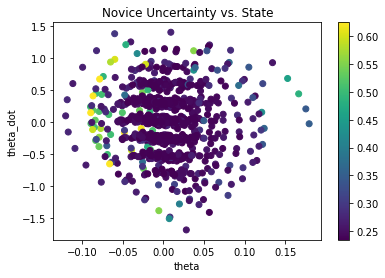

In [50]:
fig = plt.figure()
ax = plt.axes()
sc = ax.scatter(
    test_states[:, 2],
    test_states[:, 3],
    c=all_novice_uncertainties)
c_bar = plt.colorbar(sc)
plt.title("Novice Uncertainty vs. State")
plt.xlabel("theta")
plt.ylabel("theta_dot")
plt.show()

### Inference Error Visualization

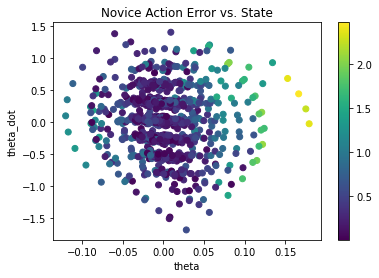

In [51]:
action_error = np.abs(all_novice_actions - test_actions.numpy())
fig = plt.figure()
ax = plt.axes()
sc = ax.scatter(test_states[:, 2], test_states[:, 3], c=action_error)
c_bar = plt.colorbar(sc)
plt.title("Novice Action Error vs. State")
plt.xlabel("theta")
plt.ylabel("theta_dot")
plt.show()